# Segment Anything Model for Burned Area Segmentation

This implementation is using the original segment anything model but only fine-tuning the mask decoder section. The encoder section is using the pre-trained weights from the original model. The input is 3 channel image + points prompt.

## 📌 Notebook Structure:

1. **Requirements and Imports**: Setting up the environment.
2. **Model Definition**: Customized U-Net architecture details.
3. **Dataset Definition**: Preprocessing and loading the data.
4. **Training Function**: Implementation of the training loop.
5. **Validation Function**: Checking model performance on unseen data.
6. **Read Data from Google Drive**: Integration with Google Drive for dataset access.
7. **Training Configs and Hyperparameters**: Setting up parameters for optimal training.
8. **Training**: Initiating the model training process.
9. **Validation and Testing**: Evaluating model performance.
10. **Visualize Results**: Displaying segmentation results visually.

In [ ]:
### Install the required libraries
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q numpy
!pip install -q matplotlib
!pip install -q opencv-python
!pip install -q PILlow
!pip install -q torch
!pip install -q monai
!pip install -q tqdm
!pip install -q thop
!pip install -q torchinfo

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from PIL import Image

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from transformers import SamModel, SamProcessor
import monai
from thop import profile
from torchinfo import summary


In [ ]:
### MODEL
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [ ]:
### DATASET
def get_bounding_box(ground_truth_map):

    image = ground_truth_map.copy().astype(np.uint8)

    kernel = np.ones((5,5),np.uint8)  # You can adjust the size based on the size of the noise
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # print(len(contours))

    points = []

    for contour in contours:
        # For each contour, get the bounding rectangle and save it to bounding_boxes
        x, y, w, h = cv2.boundingRect(contour)
        # bounding_boxes.append((x, y, w, h))

        x_min = float(x + w//2)
        y_min = float(y + h//2)

        # x_max = float(x + w)
        # y_max = float(y + h)

        points.append([x_min, y_min])

    points = [point for point in points if len(point) > 0]

    return points

class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, images_src, masks_src, processor):
        imgs = list(Path(images_src).glob("**/*.jpeg"))
        masks = list(Path(masks_src).glob("**/*.jpeg"))

        imgs = {img.stem: img for img in imgs}
        data = [[imgs[mask.stem], mask] for mask in masks if imgs.get(mask.stem)]

        self.resized_data = []

        for image_path, mask_path in tqdm(data):
            image_cv2 = cv2.imread(str(image_path))
            image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
            image_cv2 = cv2.resize(image_cv2, (256, 256))
            # image_cv2 = np.expand_dims(image_cv2, axis=0)

            mask_cv2 = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            mask_cv2 = (mask_cv2 > 127).astype(np.uint8)
            mask_cv2 = cv2.resize(mask_cv2, (256, 256))

            if mask_cv2.max() != 0:
                if len(get_bounding_box(mask_cv2)) > 0:
                    self.resized_data.append((image_cv2, mask_cv2))

        print(f"Read in {len(data)} images, resized to 256, with {len(self.resized_data)} remaining with objects")

        # images_array = np.array([pair[0] for pair in resized_data])  # Shape: (100, 256, 256, 3)
        # masks_array = np.array([pair[1] for pair in resized_data])   # Shape: (100, 256, 256)


        # self.images = images_array
        # self.masks = masks_array
        self.processor = processor

    def __len__(self):
        return len(self.resized_data)

    def __getitem__(self, idx):

        image, ground_truth_mask = self.resized_data[idx]

        image = Image.fromarray(image)

        # ground_truth_mask = np.array(self.masks[idx])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_points=[prompt], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

    def output_example(self, idx):

        image, ground_truth_mask = self.resized_data[idx]

        image = Image.fromarray(image)

        # ground_truth_mask = np.array(self.masks[idx])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_points=[prompt], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return image, inputs



In [ ]:
### TRAINING LOOP

def train(
    model,
    num_epochs,
    patience,
    train_dataloader,
    valid_dataloader,
    save_path,
    optimizer,
    scheduler,
    device,
):

    model.to(device)
    model.train()

    for epoch in range(num_epochs):

        best_loss = 999.0
        num_stop = 0
        train_loss = 0

        for batch in tqdm(train_dataloader):
            # forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_points=batch["input_points"].to(device),
                            multimask_output=False)

            # compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

            # backward pass (compute gradients of parameters w.r.t. loss)
            optimizer.zero_grad()
            loss.backward()

            # optimize
            optimizer.step()

            train_loss += loss.item()

        num_batch = len(train_dataloader)
        avg_train_loss = train_loss / num_batch

        val_loss, accuracy = validate_model(model, valid_dataloader, device)
        f1_score = accuracy['avg_f1']

        if val_loss < best_loss:
            best_loss = val_loss
            num_stop = 0
            torch.save(model.state_dict(), save_path + "/best_model.pth")
        else:
            num_stop += 1

        if num_stop == patience:
            print("Early stopping")
            break

        scheduler.step()
        curr_lr = optimizer.param_groups[0]['lr']

        print(f'EPOCH: {epoch}, LR: {curr_lr}')
        print(f'Train loss: {avg_train_loss}, Val loss: {val_loss}, Val F1: {f1_score}')

    torch.save(model.state_dict(), save_path + "/best_model.pth")



In [ ]:
### VALIDATION LOOP
def get_f1(label, predict):
    # dice acc
    predict = (predict > 0.5).astype(np.float32)

    intersection = (predict * label).sum()

    f1_acc = (2 * intersection) / (label.sum() + predict.sum() + 1e-8)

    return f1_acc

def get_iou(label, predict):
    predict = (predict > 0.5).astype(np.float32)

    intersection = (predict * label).sum()
    union = label.sum() + predict.sum() - intersection

    return (intersection + 1e-8) / (union + 1e-8)

def get_mcc(label, predict):
    predict = (predict > 0.5).astype(np.float32)

    tp = (predict * label).sum()
    fp = (predict * (1 - label)).sum()
    fn = ((1 - predict) * label).sum()
    tn = ((1 - predict) * (1 - label)).sum()

    numerator = tp * tn - fp * fn
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    return numerator / (denominator + 1e-8)

def validate_model(
    model,
    dataloader,
    device,
):

    running_f1 = 0
    running_iou = 0
    running_mcc = 0
    running_loss = 0
    n = 0
    model.eval()
    # forward pass
    with torch.no_grad():
        for batch in tqdm(dataloader):

            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_points=batch["input_points"].to(device),
                            multimask_output=False)

            # compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            running_loss += loss.item()

            # apply sigmoid
            medsam_seg_prob = torch.sigmoid(predicted_masks)
            # convert soft mask to hard mask
            medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob > 0.9).astype(np.uint8)
            ground_truth_mask = np.array(batch["ground_truth_mask"].squeeze())

            running_f1 += get_f1(ground_truth_mask, medsam_seg)
            running_iou += get_iou(ground_truth_mask, medsam_seg)
            running_mcc += get_mcc(ground_truth_mask, medsam_seg)

            n += 1
    avg_running_loss = running_loss / n
    accuracy = {}
    accuracy['avg_f1'] = running_f1 / n
    accuracy['avg_iou'] = running_iou / n
    accuracy['avg_mcc'] = running_mcc / n

    return avg_running_loss, accuracy

In [ ]:
### READ DATA

ROOT = "/content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset"
MODEL_SAVE_PATH = "/content/drive/MyDrive/ResearchProject/models/SAM"

TRAIN_IMG_DIR = ROOT + "/images/train_images"
TRAIN_MASK_DIR = ROOT + "/masks/train_masks"
VAL_IMG_DIR = ROOT + "/images/val_images"
VAL_MASK_DIR = ROOT + "/masks/val_masks"
TEST_IMG_DIR = ROOT + '/images/test_images'
TEST_MASK_DIR = ROOT + '/masks/test_masks'
VISUAL_IMG_DIR = ROOT + '/images/visual_check_images'
VISUAL_MASK_DIR = ROOT + '/masks/visual_check_masks'

BATCH_SIZE = 1
IMG_SIZE = 512

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

train_dataset = SAMDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, processor)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)

valid_dataset = SAMDataset(VAL_IMG_DIR, VAL_MASK_DIR, processor)
valid_dataloader = DataLoader(valid_dataset, batch_size=1)

test_dataset = SAMDataset(TEST_IMG_DIR, TEST_MASK_DIR, processor)
test_dataloader = DataLoader(test_dataset, batch_size=1)

visual_dataset = SAMDataset(VISUAL_IMG_DIR, VISUAL_MASK_DIR, processor)
visual_dataloader = DataLoader(visual_dataset, batch_size=1)

100%|██████████| 1388/1388 [00:23<00:00, 59.78it/s]


Read in 1388 images, resized to 256, with 974 remaining with objects


100%|██████████| 288/288 [00:03<00:00, 90.15it/s]


Read in 288 images, resized to 256, with 216 remaining with objects


100%|██████████| 300/300 [00:04<00:00, 73.40it/s]


Read in 300 images, resized to 256, with 156 remaining with objects


100%|██████████| 6/6 [00:00<00:00, 59.74it/s]

Read in 6 images, resized to 256, with 6 remaining with objects


803
(256, 256, 3)
(256, 256)


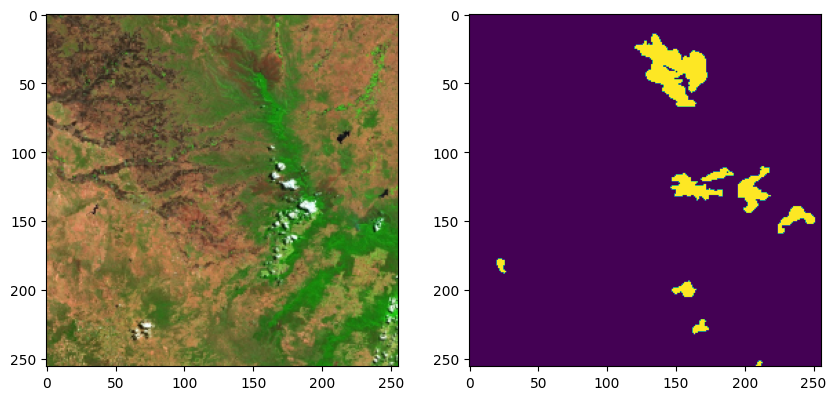

In [ ]:
# sanity check
random_int = random.randint(0, len(train_dataset)-1)
print(random_int)

# random_int = 973
image, input = train_dataset.output_example(random_int)

image = np.array(image)

mask = input['ground_truth_mask']

print(image.shape)
print(mask.shape)

# mask = mask.permute(1,2,0)
# mask = mask.squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask)

plt.show()

In [ ]:
### START TRAINING
load = True
if load:
    # model.load_state_dict(torch.load(MODEL_SAVE_PATH + '/best_model.pth'))
    model.load_state_dict(torch.load('/content/drive/MyDrive/ResearchProject/codes/SAM/runs/run2_point_uni_data/best.pth'))

summary(model, (BATCH_SIZE, 3, IMG_SIZE*2, IMG_SIZE*2))

Layer (type:depth-idx)                             Output Shape              Param #
SamModel                                           [1, 1, 3, 256, 256]       --
├─SamPromptEncoder: 1-1                            --                        (recursive)
│    └─SamPositionalEmbedding: 2-1                 [64, 64, 256]             --
├─SamVisionEncoder: 1-2                            [1, 256, 64, 64]          3,145,728
│    └─SamPatchEmbeddings: 2-2                     [1, 64, 64, 768]          --
│    │    └─Conv2d: 3-1                            [1, 768, 64, 64]          (590,592)
│    └─ModuleList: 2-3                             --                        --
│    │    └─SamVisionLayer: 3-2                    [1, 64, 64, 768]          (7,091,328)
│    │    └─SamVisionLayer: 3-3                    [1, 64, 64, 768]          (7,091,328)
│    │    └─SamVisionLayer: 3-4                    [1, 64, 64, 768]          (7,104,128)
│    │    └─SamVisionLayer: 3-5                    [1, 64, 64, 76

In [ ]:
input_tensor = torch.randn(1, 3, 1024, 1024).to('cuda')
flops, params = profile(model, inputs=(input_tensor,))
print(f"Flops: {flops:,}, Params: {params:,}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
Flops: 371,983,126,528.0, Params: 90,488,420.0


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using CUDA")
else:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("using MPS")
    else:
        device = torch.device("cpu")
        print("using CPU")

NUM_EPOCHS = 500
PATIENCE = 100
LEARNING_RATE_0 = 0.0001
LEARNING_RATE_F = LEARNING_RATE_0 * 0.1
WEIGHT_DECAY = 5e-4

optimizer = Adam(model.mask_decoder.parameters(), lr=LEARNING_RATE_0, weight_decay=WEIGHT_DECAY)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = NUM_EPOCHS, eta_min=1e-5)

train(model=model,
      num_epochs=NUM_EPOCHS,
      patience=PATIENCE,
      train_dataloader=train_dataloader,
      valid_dataloader=valid_dataloader,
      save_path=MODEL_SAVE_PATH,
      optimizer=optimizer,
      scheduler=scheduler,
      device=device)

In [ ]:
### VALIDATION
loss, accuracy = validate_model(model, train_dataloader, device)

In [ ]:
for k, v in accuracy.items():
    print(k, v)

In [ ]:
### VALIDATION
loss, accuracy = validate_model(model, valid_dataloader, device)

100%|██████████| 216/216 [01:38<00:00,  2.20it/s]


In [ ]:
for k, v in accuracy.items():
    print(k, v)

avg_f1 0.5310162789310562
avg_iou 0.3830899922344705
avg_mcc 0.5436373553725805


In [ ]:
### TESTING
loss, accuracy = validate_model(model, test_dataloader, device)
for k, v in accuracy.items():
    print(k, v)

100%|██████████| 156/156 [01:19<00:00,  1.95it/s]

avg_f1 0.6898522655850694
avg_iou 0.5631133680778325
avg_mcc 0.6907317524368605


  0%|          | 0/6 [00:00<?, ?it/s]

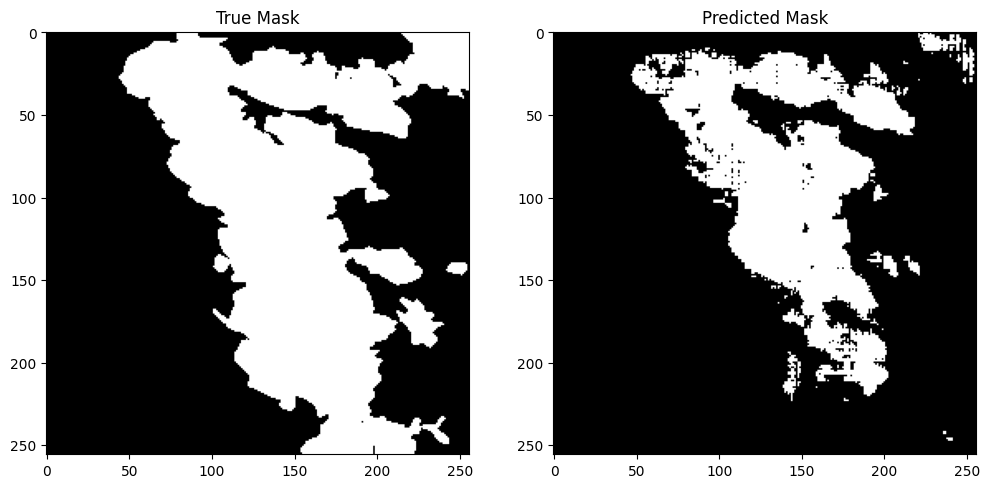

 17%|█▋        | 1/6 [00:01<00:05,  1.19s/it]

F1:  0.7210479309316461


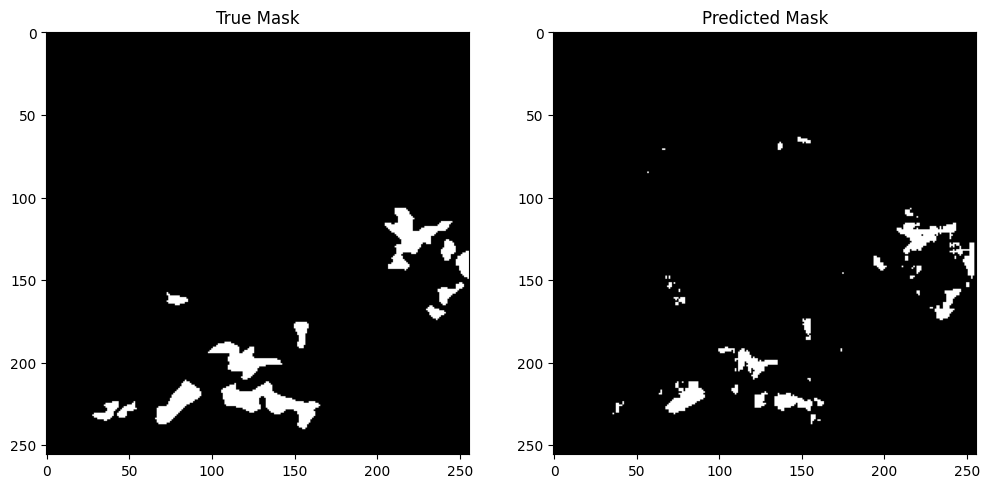

 33%|███▎      | 2/6 [00:02<00:04,  1.13s/it]

F1:  0.6126482213423601


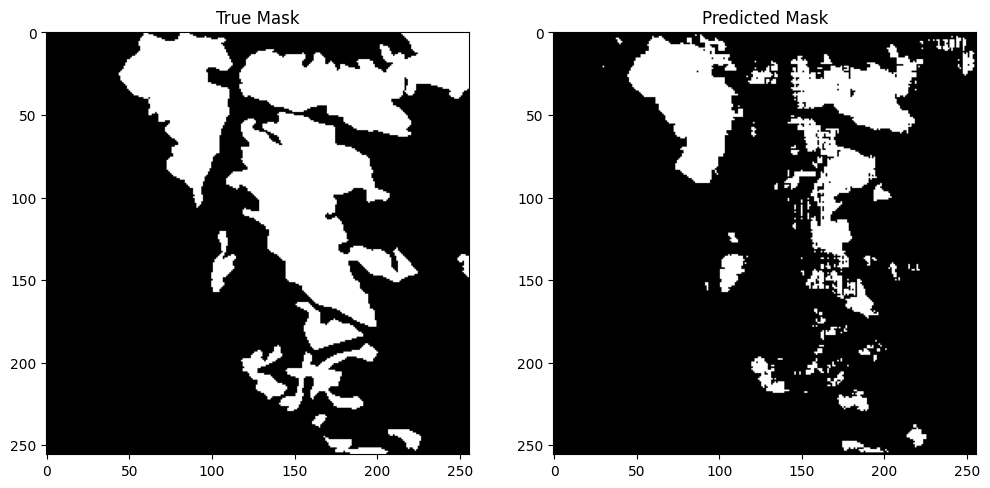

 50%|█████     | 3/6 [00:03<00:03,  1.15s/it]

F1:  0.6664182996793583


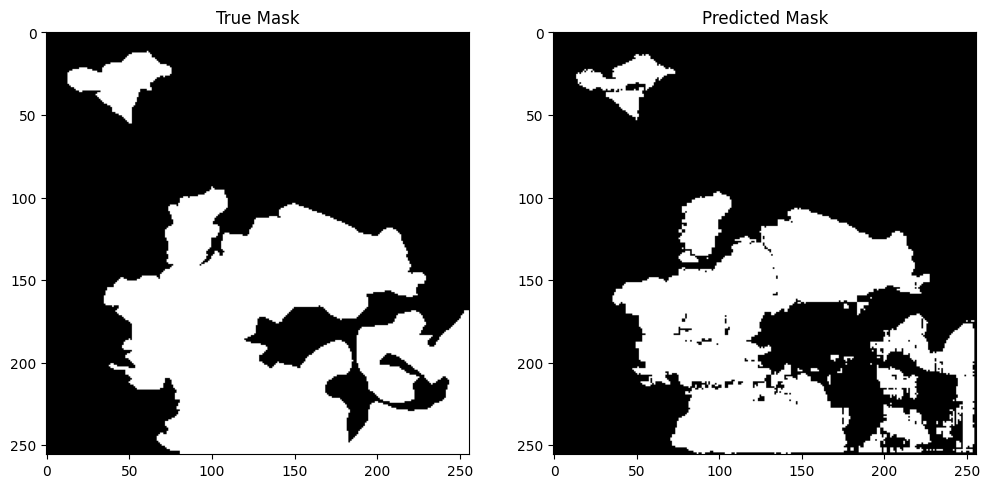

 67%|██████▋   | 4/6 [00:04<00:02,  1.13s/it]

F1:  0.86943142204571


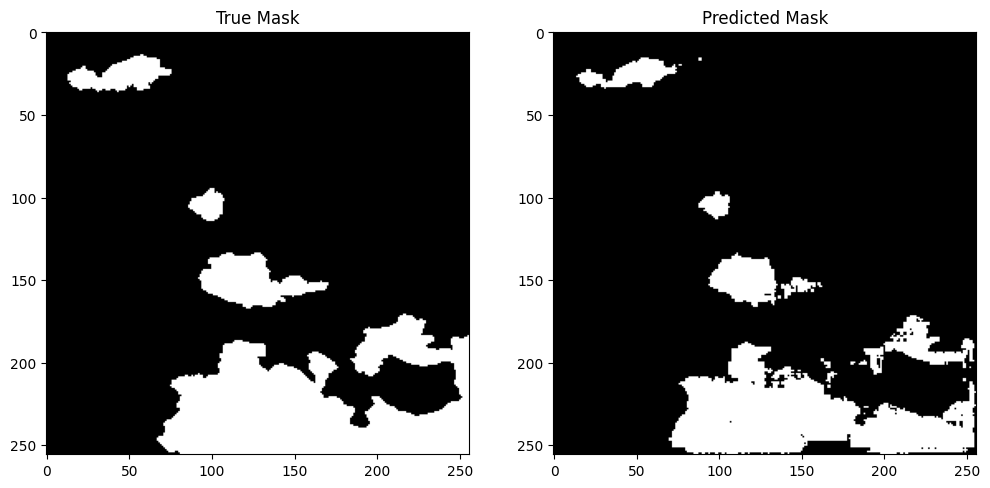

 83%|████████▎ | 5/6 [00:05<00:01,  1.04s/it]

F1:  0.8744997141219389


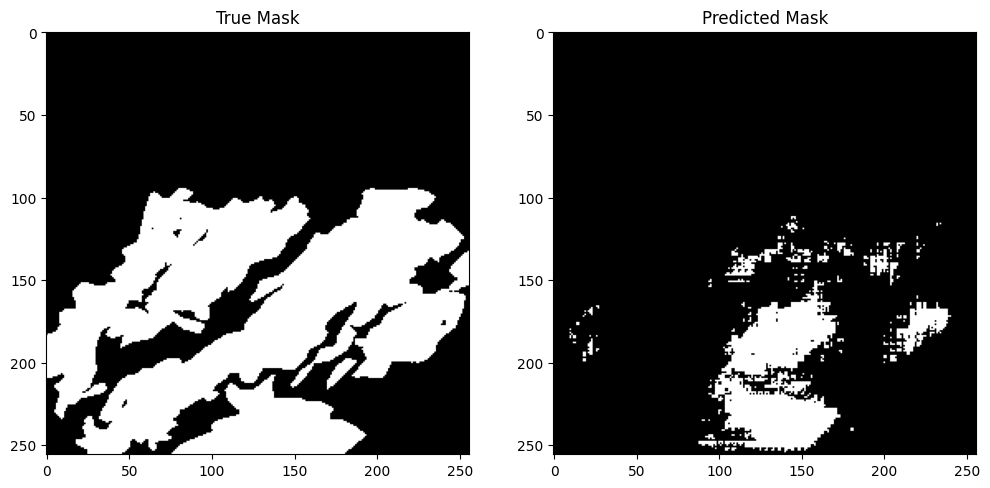

100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

F1:  0.3414960524553922


In [ ]:
### VISUALIZATION
# check avg acc from all validate images
running_f1 = 0
n = 0

for batch in tqdm(visual_dataloader):

    model.eval()
    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_points=batch["input_points"].to(device),
                        multimask_output=False)

    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.9).astype(np.uint8)

    ground_truth_mask = np.array(batch["ground_truth_mask"].squeeze())

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(ground_truth_mask, cmap='gray')  # True mask
    plt.title('True Mask')

    plt.subplot(1, 2, 2)
    plt.imshow(medsam_seg, cmap='gray')  # Predicted mask
    plt.title('Predicted Mask')



    plt.show()

    print("F1: ", get_f1(ground_truth_mask, medsam_seg))


